In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import pandas as pd

# Stage I: Download and preprocess AAPL data
ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2030-12-31', progress=False)
prices = data['Close'].values.reshape(-1, 1)  # Use closing prices

# Scale data
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

# Create sequences (10 timesteps to predict next day)
timesteps = 10
X, y = [], []
for i in range(len(prices_scaled) - timesteps):
    X.append(prices_scaled[i:i + timesteps])
    y.append(prices_scaled[i + timesteps])
X, y = np.array(X).astype(np.float32), np.array(y).astype(np.float32)

# Split into train and test (80-20)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

/tmp/ipython-input-3363199138.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2020-01-01', end='2030-12-31', progress=False)


In [2]:
# Stage II: Define SimpleRNN model
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, input_shape=(timesteps, 1), return_sequences=False), # return_sequence importance!!!!!!
    tf.keras.layers.Dense(1)  # Regression output
])

# Stage III: Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae'])

# Stage IV: Train with validation
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0397 - mae: 0.1531 - val_loss: 0.0134 - val_mae: 0.1012
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mae: 0.0372 - val_loss: 0.0084 - val_mae: 0.0781
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0718
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - mae: 0.0298 - val_loss: 0.0075 - val_mae: 0.0752
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012 - mae: 0.0270 - val_loss: 0.0051 - val_mae: 0.0604
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011 - mae: 0.0254 - val_loss: 0.0041 - val_mae: 0.0535
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.2028e-04 - mae: 0.0238 - val_loss: 0.0039 - val_mae: 0.0523
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.7610e-04 - mae: 0.0218 - val_loss: 0.0039 - val_mae: 0.0530
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.3013e-04

In [3]:
# Stage V: Evaluate on test data
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f'SimpleRNN Test Loss (MSE): {test_loss:.4f}, Test MAE: {test_mae:.4f}')

# Extract metrics from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']
epochs_range = range(1, len(train_loss) + 1)

SimpleRNN Test Loss (MSE): 0.0018, Test MAE: 0.0326


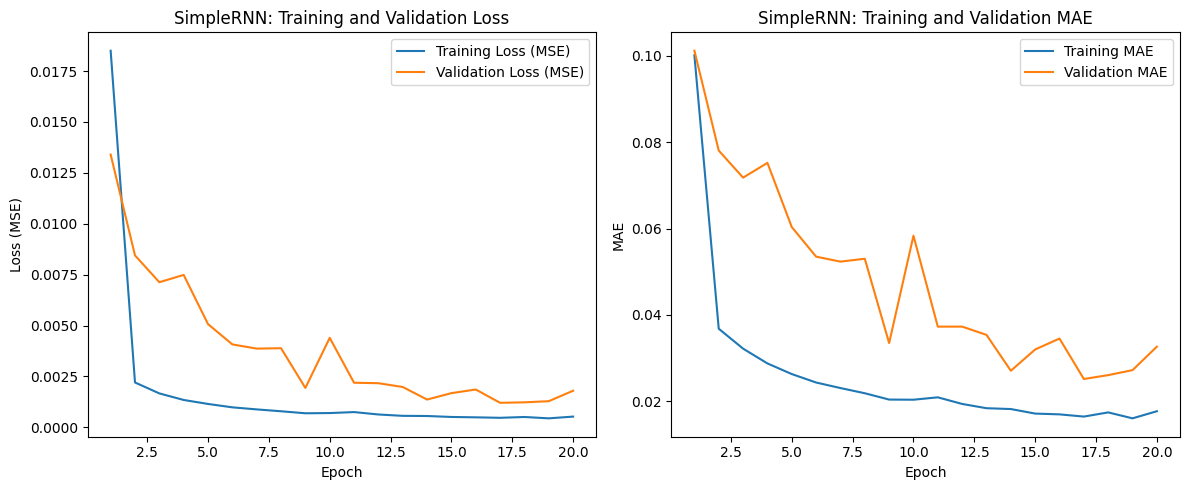

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


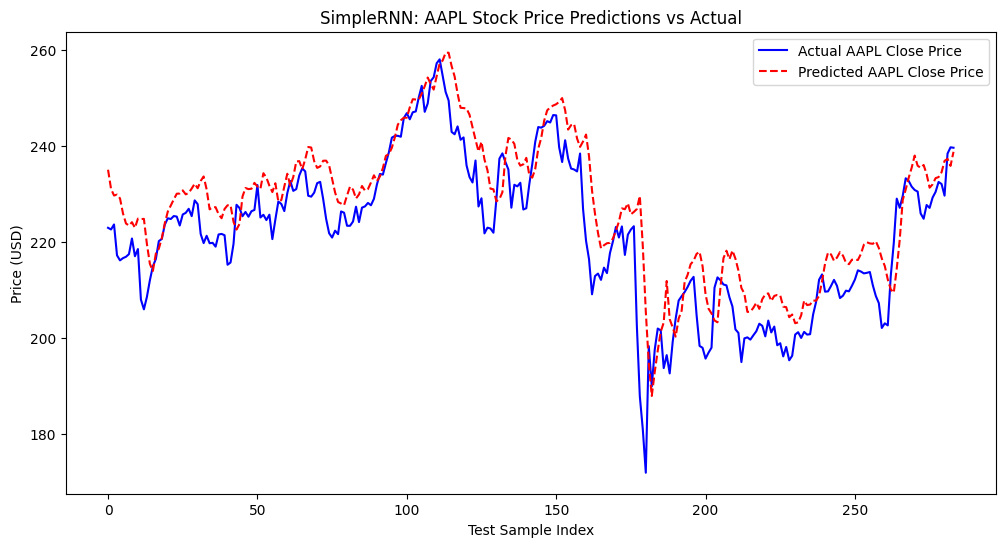

In [4]:
# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss (MSE)')
plt.plot(epochs_range, val_loss, label='Validation Loss (MSE)')
plt.title('SimpleRNN: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.title('SimpleRNN: Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Predictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)  # Inverse scale predictions
y_test_actual = scaler.inverse_transform(y_test)  # Inverse scale actual values

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual AAPL Close Price', color='blue')
plt.plot(y_pred, label='Predicted AAPL Close Price', color='red', linestyle='--')
plt.title('SimpleRNN: AAPL Stock Price Predictions vs Actual')
plt.xlabel('Test Sample Index')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [5]:
# Stage II: Define LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(timesteps, 1), return_sequences=False), # return_sequence importance!!!!!!
    tf.keras.layers.Dense(1)  # Regression output
])

# Stage III: Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae'])

# Stage IV: Train with validation
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1037 - mae: 0.2534 - val_loss: 0.0288 - val_mae: 0.1646
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0034 - mae: 0.0463 - val_loss: 0.0030 - val_mae: 0.0454
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - mae: 0.0275 - val_loss: 0.0016 - val_mae: 0.0303
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.2996e-04 - mae: 0.0219 - val_loss: 0.0017 - val_mae: 0.0304
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4421e-04 - mae: 0.0201 - val_loss: 0.0020 - val_mae: 0.0324
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.3807e-04 - mae: 0.0201 - val_loss: 0.0017 - val_mae: 0.0305
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.6061e-04 - mae: 0.0202 - val_loss: 0.0017 - val_mae: 0.0304
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.0118e-04 - mae: 0.0207 - val_loss: 0.0020 - val_mae: 0.0321
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss:

In [6]:
# Stage II: Define GRU model
model = tf.keras.Sequential([
    tf.keras.layers.GRU(64, input_shape=(timesteps, 1), return_sequences=False),
    tf.keras.layers.Dense(1)  # Regression output
])

# Stage III: Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae'])

# Stage IV: Train with validation
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0864 - mae: 0.2298 - val_loss: 0.0342 - val_mae: 0.1808
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - mae: 0.0521 - val_loss: 0.0084 - val_mae: 0.0874
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0016 - mae: 0.0305 - val_loss: 0.0016 - val_mae: 0.0331
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.6663e-04 - mae: 0.0190 - val_loss: 9.7744e-04 - val_mae: 0.0220
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.6155e-04 - mae: 0.0144 - val_loss: 9.2730e-04 - val_mae: 0.0218
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.5437e-04 - mae: 0.0146 - val_loss: 9.1818e-04 - val_mae: 0.0213
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.3668e-04 - mae: 0.0141 - val_loss: 0.0010 - val_mae: 0.0225
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.3589e-04 - mae: 0.0143 - val_loss: 9.2473e-04 - val_mae: 0.0213
Epoch 9/20
36/36 ━━━━━━━━━━━

In [7]:
# Stage II: Define Stacked LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(timesteps, 1), return_sequences=True),  # First LSTM layer
    tf.keras.layers.LSTM(64, return_sequences=False),  # Second LSTM layer
    tf.keras.layers.Dense(1)  # Regression output
])

# Stage III: Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae'])

# Stage IV: Train with validation
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0862 - mae: 0.2282 - val_loss: 0.0018 - val_mae: 0.0318
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0029 - mae: 0.0427 - val_loss: 0.0025 - val_mae: 0.0410
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 8.4917e-04 - mae: 0.0231 - val_loss: 0.0019 - val_mae: 0.0324
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.9135e-04 - mae: 0.0208 - val_loss: 0.0019 - val_mae: 0.0323
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.9062e-04 - mae: 0.0223 - val_loss: 0.0021 - val_mae: 0.0336
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.1387e-04 - mae: 0.0209 - val_loss: 0.0020 - val_mae: 0.0324
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.9277e-04 - mae: 0.0208 - val_loss: 0.0021 - val_mae: 0.0333
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.9619e-04 - mae: 0.0208 - val_loss: 0.0020 - val_mae: 0.0324
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s

In [8]:
# Stage II: Define BiLSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=False),
        input_shape=(timesteps, 1)
    ),  # BiLSTM layer
    tf.keras.layers.Dense(1)  # Regression output
])

# Stage III: Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae'])

# Stage IV: Train with validation
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.1441 - mae: 0.2979 - val_loss: 0.0322 - val_mae: 0.1743
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0041 - mae: 0.0501 - val_loss: 0.0053 - val_mae: 0.0644
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014 - mae: 0.0298 - val_loss: 0.0018 - val_mae: 0.0333
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.7983e-04 - mae: 0.0221 - val_loss: 0.0020 - val_mae: 0.0325
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.1973e-04 - mae: 0.0213 - val_loss: 0.0022 - val_mae: 0.0336
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.6646e-04 - mae: 0.0207 - val_loss: 0.0026 - val_mae: 0.0377
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.6351e-04 - mae: 0.0203 - val_loss: 0.0023 - val_mae: 0.0353
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.8991e-04 - mae: 0.0206 - val_loss: 0.0021 - val_mae: 0.0331
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - lo

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import pandas as pd

# Function to build SimpleRNN model
def build_simple_rnn(timesteps):
    model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(64, input_shape=(timesteps, 1), return_sequences=False),
        tf.keras.layers.Dense(1)
    ])
    return model

# Function to build LSTM model
def build_lstm(timesteps):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, input_shape=(timesteps, 1), return_sequences=False),
        tf.keras.layers.Dense(1)
    ])
    return model

# Function to build GRU model
def build_gru(timesteps):
    model = tf.keras.Sequential([
        tf.keras.layers.GRU(64, input_shape=(timesteps, 1), return_sequences=False),
        tf.keras.layers.Dense(1)
    ])
    return model

# Function to build Stacked LSTM model
def build_stacked_lstm(timesteps):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, input_shape=(timesteps, 1), return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=False),
        tf.keras.layers.Dense(1)
    ])
    return model

# Function to build BiLSTM model (corrected)
def build_bi_lstm(timesteps):
    model = tf.keras.Sequential([
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(64, return_sequences=False),
            input_shape=(timesteps, 1)
        ),
        tf.keras.layers.Dense(1)  # Regression output
    ])
    return model

In [15]:
# Stage I: Download and preprocess AAPL data
ticker = 'AAPL'
try:
    data = yf.download(ticker, start='2020-01-01', end='2025-01-01', progress=False)
    if data.empty:
        raise ValueError("No data downloaded for ticker.")
except Exception as e:
    print(f"Error downloading data: {e}")
    exit(1)

prices = data['Close'].values.reshape(-1, 1)  # Use closing prices

# Scale data
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

# Create sequences (10 timesteps to predict next day)
timesteps = 10
X, y = [], []
for i in range(len(prices_scaled) - timesteps):
    X.append(prices_scaled[i:i + timesteps])
    y.append(prices_scaled[i + timesteps])
X_seq, y = np.array(X).astype(np.float32), np.array(y).astype(np.float32)  # 3D for RNNs

# Split into train and test (80-20)
train_size = int(0.8 * len(X_seq))
X_train_seq, X_test_seq = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

/tmp/ipython-input-2509449798.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2020-01-01', end='2025-01-01', progress=False)


In [18]:
# Compile and train function
def train_and_evaluate(model, X_train_seq, y_train, X_test_seq, y_test, model_name):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mae'])

    history = model.fit(X_train_seq, y_train, epochs=20, batch_size=32, verbose=1,
                        validation_data=(X_test_seq, y_test))

    test_loss, test_mae = model.evaluate(X_test_seq, y_test, verbose=0)
    print(f'{model_name} Test Loss (MSE): {test_loss:.4f}, Test MAE: {test_mae:.4f}')

    # Predictions
    y_pred_scaled = model.predict(X_test_seq, verbose=0)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))  # Ensure 2D for inverse transform

    return history, test_mae, y_pred, y_test_actual

In [19]:
# Train all models
models = {
    'SimpleRNN': build_simple_rnn(timesteps),
    'LSTM': build_lstm(timesteps),
    'GRU': build_gru(timesteps),
    'Stacked LSTM': build_stacked_lstm(timesteps),
    'Bi-LSTM': build_bi_lstm(timesteps)
}

results = {}
histories = {}
all_predictions = {}
y_actual = None  # Store actual values (same for all models)

for name, model in models.items():
    history, test_mae, y_pred, y_test_actual = train_and_evaluate(
        model, X_train_seq, y_train, X_test_seq, y_test, name
    )
    results[name] = test_mae
    histories[name] = history
    all_predictions[name] = y_pred
    y_actual = y_test_actual  # Same for all models

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0108 - mae: 0.0778 - val_loss: 0.0086 - val_mae: 0.0750
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.7065e-04 - mae: 0.0224 - val_loss: 0.0046 - val_mae: 0.0543
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.6107e-04 - mae: 0.0199 - val_loss: 0.0045 - val_mae: 0.0552
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8998e-04 - mae: 0.0175 - val_loss: 0.0022 - val_mae: 0.0374
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7767e-04 - mae: 0.0171 - val_loss: 0.0029 - val_mae: 0.0453
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2528e-04 - mae: 0.0162 - val_loss: 0.0010 - val_mae: 0.0256
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2851e-04 - mae: 0.0161 - val_loss: 0.0015 - val_mae: 0.0310
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7726e-04 - mae: 0.0152 - val_loss: 0.0018 - val_mae: 0.0358
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6m

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0727 - mae: 0.2195 - val_loss: 0.0284 - val_mae: 0.1606
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0035 - mae: 0.0484 - val_loss: 0.0057 - val_mae: 0.0671
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0012 - mae: 0.0286 - val_loss: 0.0010 - val_mae: 0.0252
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.1429e-04 - mae: 0.0198 - val_loss: 8.0515e-04 - val_mae: 0.0223
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5606e-04 - mae: 0.0189 - val_loss: 7.6337e-04 - val_mae: 0.0221
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.3567e-04 - mae: 0.0185 - val_loss: 7.5178e-04 - val_mae: 0.0218
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.5923e-04 - mae: 0.0186 - val_loss: 7.0142e-04 - val_mae: 0.0208
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.3128e-04 - mae: 0.0183 - val_loss: 6.8933e-04 - val_mae: 0.0208
Epoch 9/20
32/32 ━━━━━━━

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0678 - mae: 0.2066 - val_loss: 0.0295 - val_mae: 0.1623
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0039 - mae: 0.0502 - val_loss: 0.0085 - val_mae: 0.0831
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - mae: 0.0316 - val_loss: 0.0020 - val_mae: 0.0381
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.5902e-04 - mae: 0.0187 - val_loss: 7.0051e-04 - val_mae: 0.0212
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6268e-04 - mae: 0.0149 - val_loss: 4.5106e-04 - val_mae: 0.0168
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0841e-04 - mae: 0.0135 - val_loss: 4.4718e-04 - val_mae: 0.0168
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.0358e-04 - mae: 0.0134 - val_loss: 4.1917e-04 - val_mae: 0.0159
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1489e-04 - mae: 0.0135 - val_loss: 4.7481e-04 - val_mae: 0.0174
Epoch 9/20
32/32 ━━━━━━━

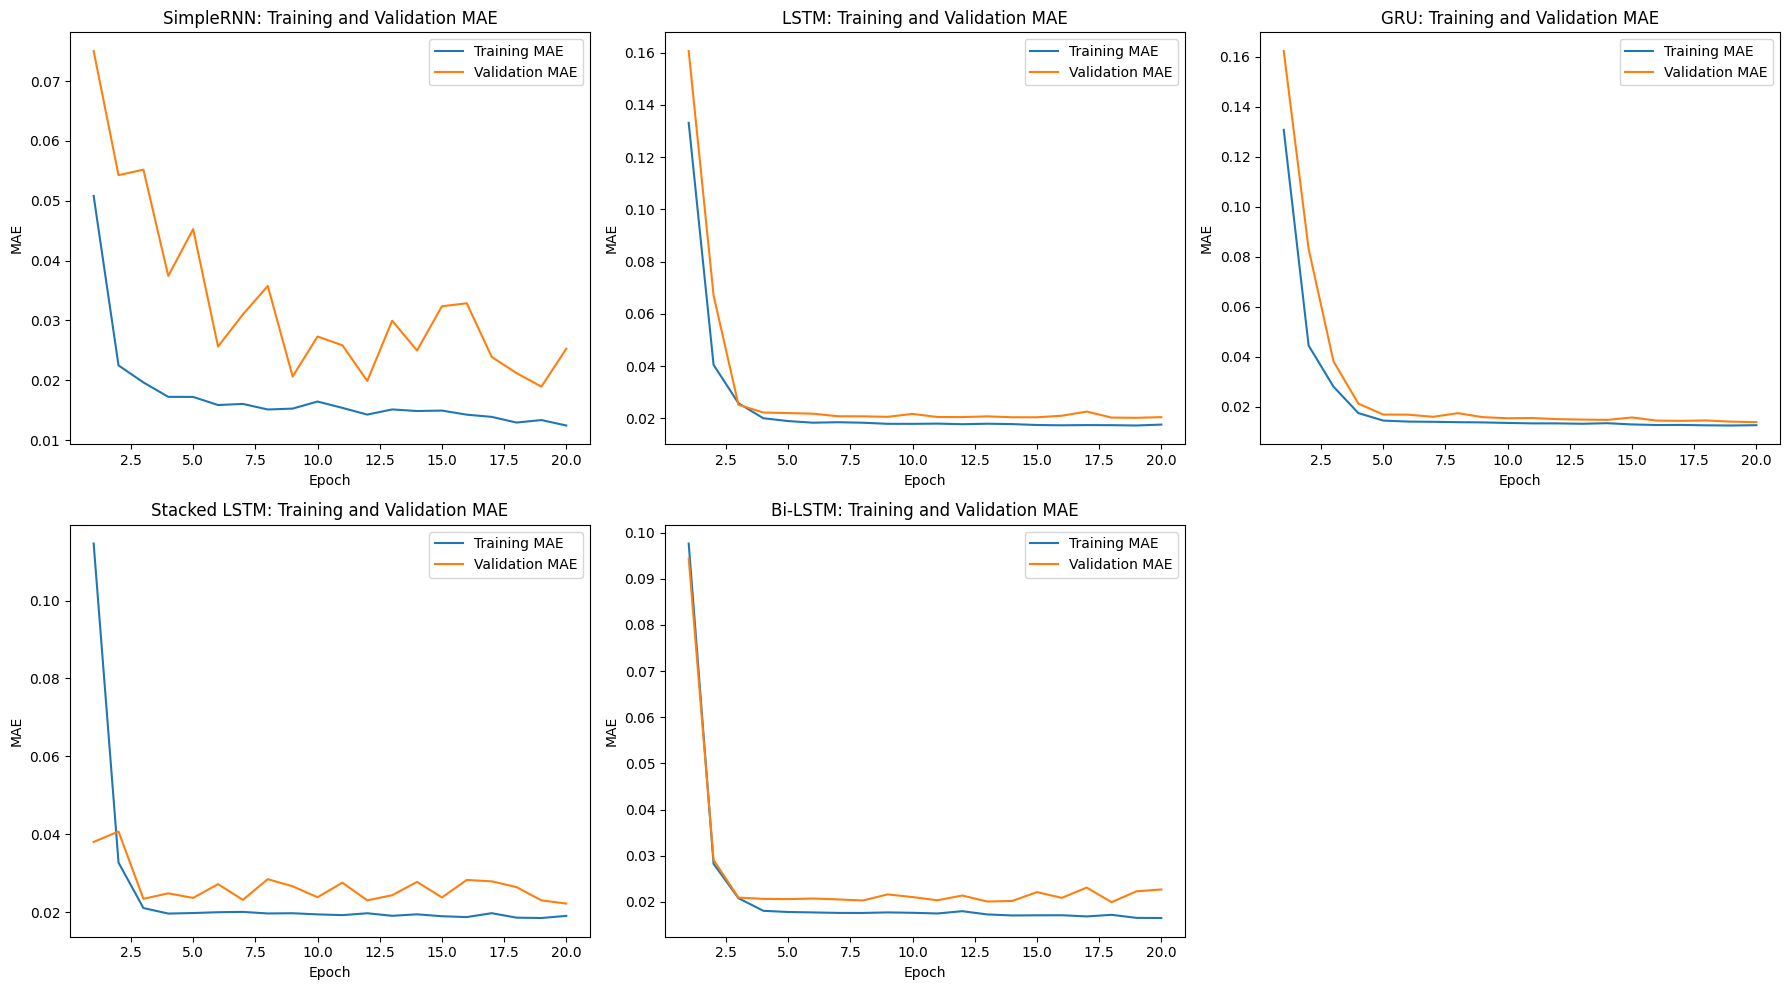

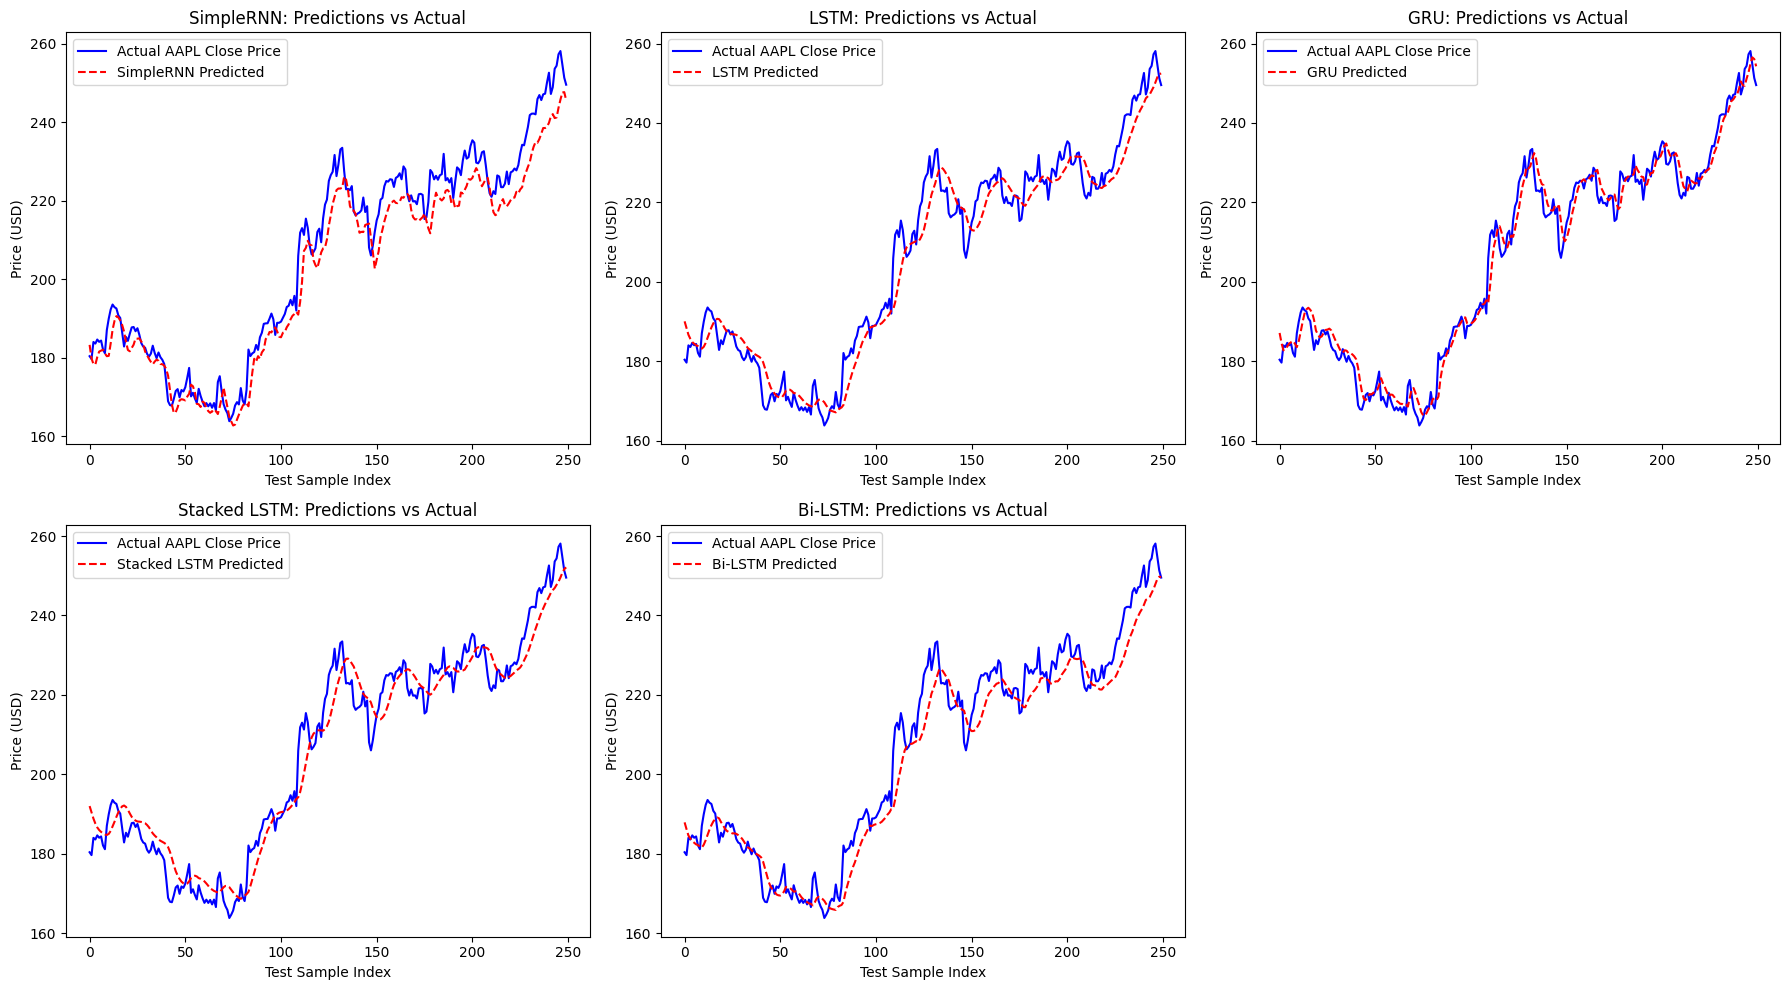

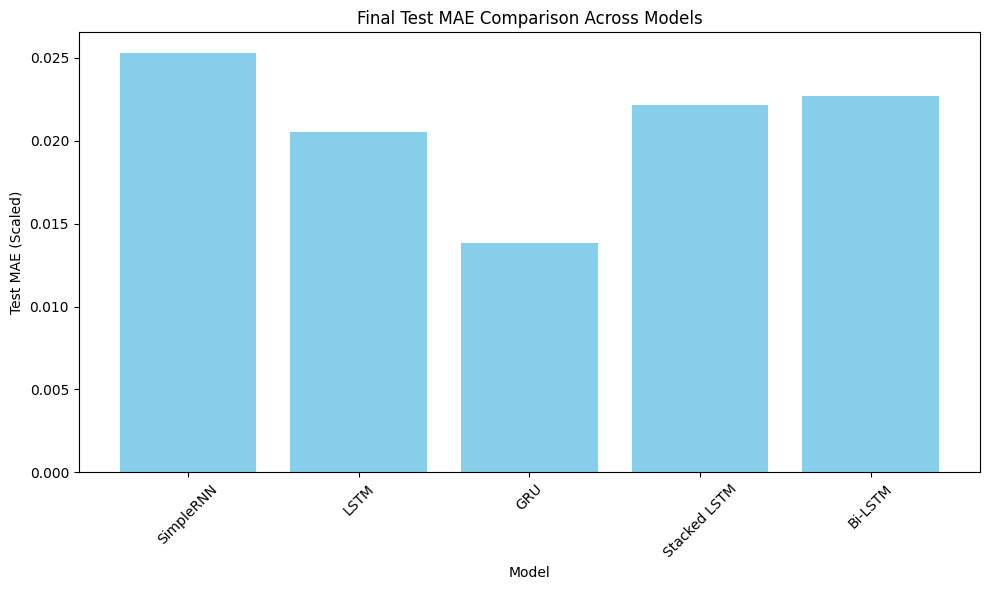


Model Performance Summary:
       Model  Test MAE (Scaled)
   SimpleRNN           0.025275
        LSTM           0.020504
         GRU           0.013817
Stacked LSTM           0.022175
     Bi-LSTM           0.022699


In [20]:
# Plot 1: Training and Validation MAE for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, (name, history) in enumerate(histories.items()):
    if idx < 5:  # Only plot for the 5 models
        epochs_range = range(1, len(history.history['mae']) + 1)
        axes[idx].plot(epochs_range, history.history['mae'], label='Training MAE')
        axes[idx].plot(epochs_range, history.history['val_mae'], label='Validation MAE')
        axes[idx].set_title(f'{name}: Training and Validation MAE')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel('MAE')
        axes[idx].legend()

# Hide the unused subplot
axes[5].axis('off')
plt.tight_layout()
plt.show()
plt.close()

# Plot 2: Predictions vs Actual for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, name in enumerate(all_predictions.keys()):
    if idx < 5:  # Only plot for the 5 models
        axes[idx].plot(y_actual.flatten(), label='Actual AAPL Close Price', color='blue')
        axes[idx].plot(all_predictions[name].flatten(), label=f'{name} Predicted', color='red', linestyle='--')
        axes[idx].set_title(f'{name}: Predictions vs Actual')
        axes[idx].set_xlabel('Test Sample Index')
        axes[idx].set_ylabel('Price (USD)')
        axes[idx].legend()

# Hide the unused subplot
axes[5].axis('off')
plt.tight_layout()
plt.show()
plt.close()

# Plot 3: Bar plot of final Test MAE
model_names = list(results.keys())
maes = list(results.values())
plt.figure(figsize=(10, 6))
plt.bar(model_names, maes, color='skyblue')
plt.title('Final Test MAE Comparison Across Models')
plt.xlabel('Model')
plt.ylabel('Test MAE (Scaled)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.close()

# Print summary table
summary_df = pd.DataFrame(list(results.items()), columns=['Model', 'Test MAE (Scaled)'])
print("\nModel Performance Summary:")
print(summary_df.to_string(index=False))